# 误警率（旧）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ysy_plot_utils as ypu
import ysy_gw_data_utils as ygdu

import json

In [2]:
from scipy.stats import expon, norm

# --- 主程序 ---
if __name__ == '__main__':
    score = []
    scores = []
    N_SLIDES = 30

    json_file_path = 'ysy_BBH_events_v3.json'
    with open(json_file_path, 'r') as f:
        all_events_data = json.load(f)
    for event_name, event_info in all_events_data.items():
        # 确保 'name' 键存在，如果不存在则使用字典的键
        if 'name' not in event_info:
            event_info['name'] = event_name
        mf_result = ygdu.matched_filtering_main_2(event_info, plot=False)
        cSNR = ygdu.caculate_coherent_snr(event_info)
        score.append(ygdu.detector_consistency_check(mf_result, cSNR, detail=True)[2])
        print('Start the time-slides analysis of '+event_name+':')
        scores = scores + ygdu.perform_time_slides(event_info, N_SLIDES)

GW150914: For detector H1, maximum at 1126259462.4395 with SNR = 18.6, D_eff = 814.45, horizon = 1889.6 Mpc
GW150914: For detector L1, maximum at 1126259462.4324 with SNR = 13.2, D_eff = 999.78, horizon = 1650.6 Mpc
Start the time-slides analysis of GW150914:
正在执行 30 次随机时域平移...
  ...已完成 1/30 次平移
  ...已完成 11/30 次平移
  ...已完成 21/30 次平移
LVT151012: For detector H1, maximum at 1128678900.4421 with SNR = 6.3, D_eff = 1577.91, horizon = 1241.5 Mpc
LVT151012: For detector L1, maximum at 1128678900.4429 with SNR = 6.1, D_eff = 1494.11, horizon = 1137.7 Mpc
Start the time-slides analysis of LVT151012:
正在执行 30 次随机时域平移...
  ...已完成 1/30 次平移
  ...已完成 11/30 次平移
  ...已完成 21/30 次平移
GW151226: For detector H1, maximum at 1135136350.6477 with SNR = 9.6, D_eff = 714.72, horizon = 858.5 Mpc
GW151226: For detector L1, maximum at 1135136350.6465 with SNR = 7.2, D_eff = 683.64, horizon = 614.8 Mpc
Start the time-slides analysis of GW151226:
正在执行 30 次随机时域平移...
  ...已完成 1/30 次平移
  ...已完成 11/30 次平移
  ...已完成 21/30 

In [7]:
tot_N = N_SLIDES * 4
S_real = np.max(score)
background_scores = np.array(scores)
print("\n--- 评估结果 ---")
# --- 方法一：直接计数法 ---
print("\n[方法一：直接计数法]")
n_louder = np.sum(background_scores <= S_real)
fap_direct = n_louder / tot_N
print(f"在 {tot_N} 次平移中，发现 {n_louder} 个噪声事件得分高于真实事件。")
print(f"由此估计的假警报概率 (FAP) 为: {fap_direct:.4f} (或 {fap_direct*100:.2f}%)")
if n_louder == 0:
    print(f"这意味着FAP的上限为 < {1/tot_N:.4f}")


--- 评估结果 ---

[方法一：直接计数法]
在 120 次平移中，发现 32 个噪声事件得分高于真实事件。
由此估计的假警报概率 (FAP) 为: 0.2667 (或 26.67%)



正态分布拟合外推法
拟合的正态分布参数: μ (均值) = 0.52, σ (标准差) = 0.15
根据拟合分布，得分>=0.47的概率(FAP)为: 6.35e-01
对应的统计显著性为: -0.35 σ (sigma)


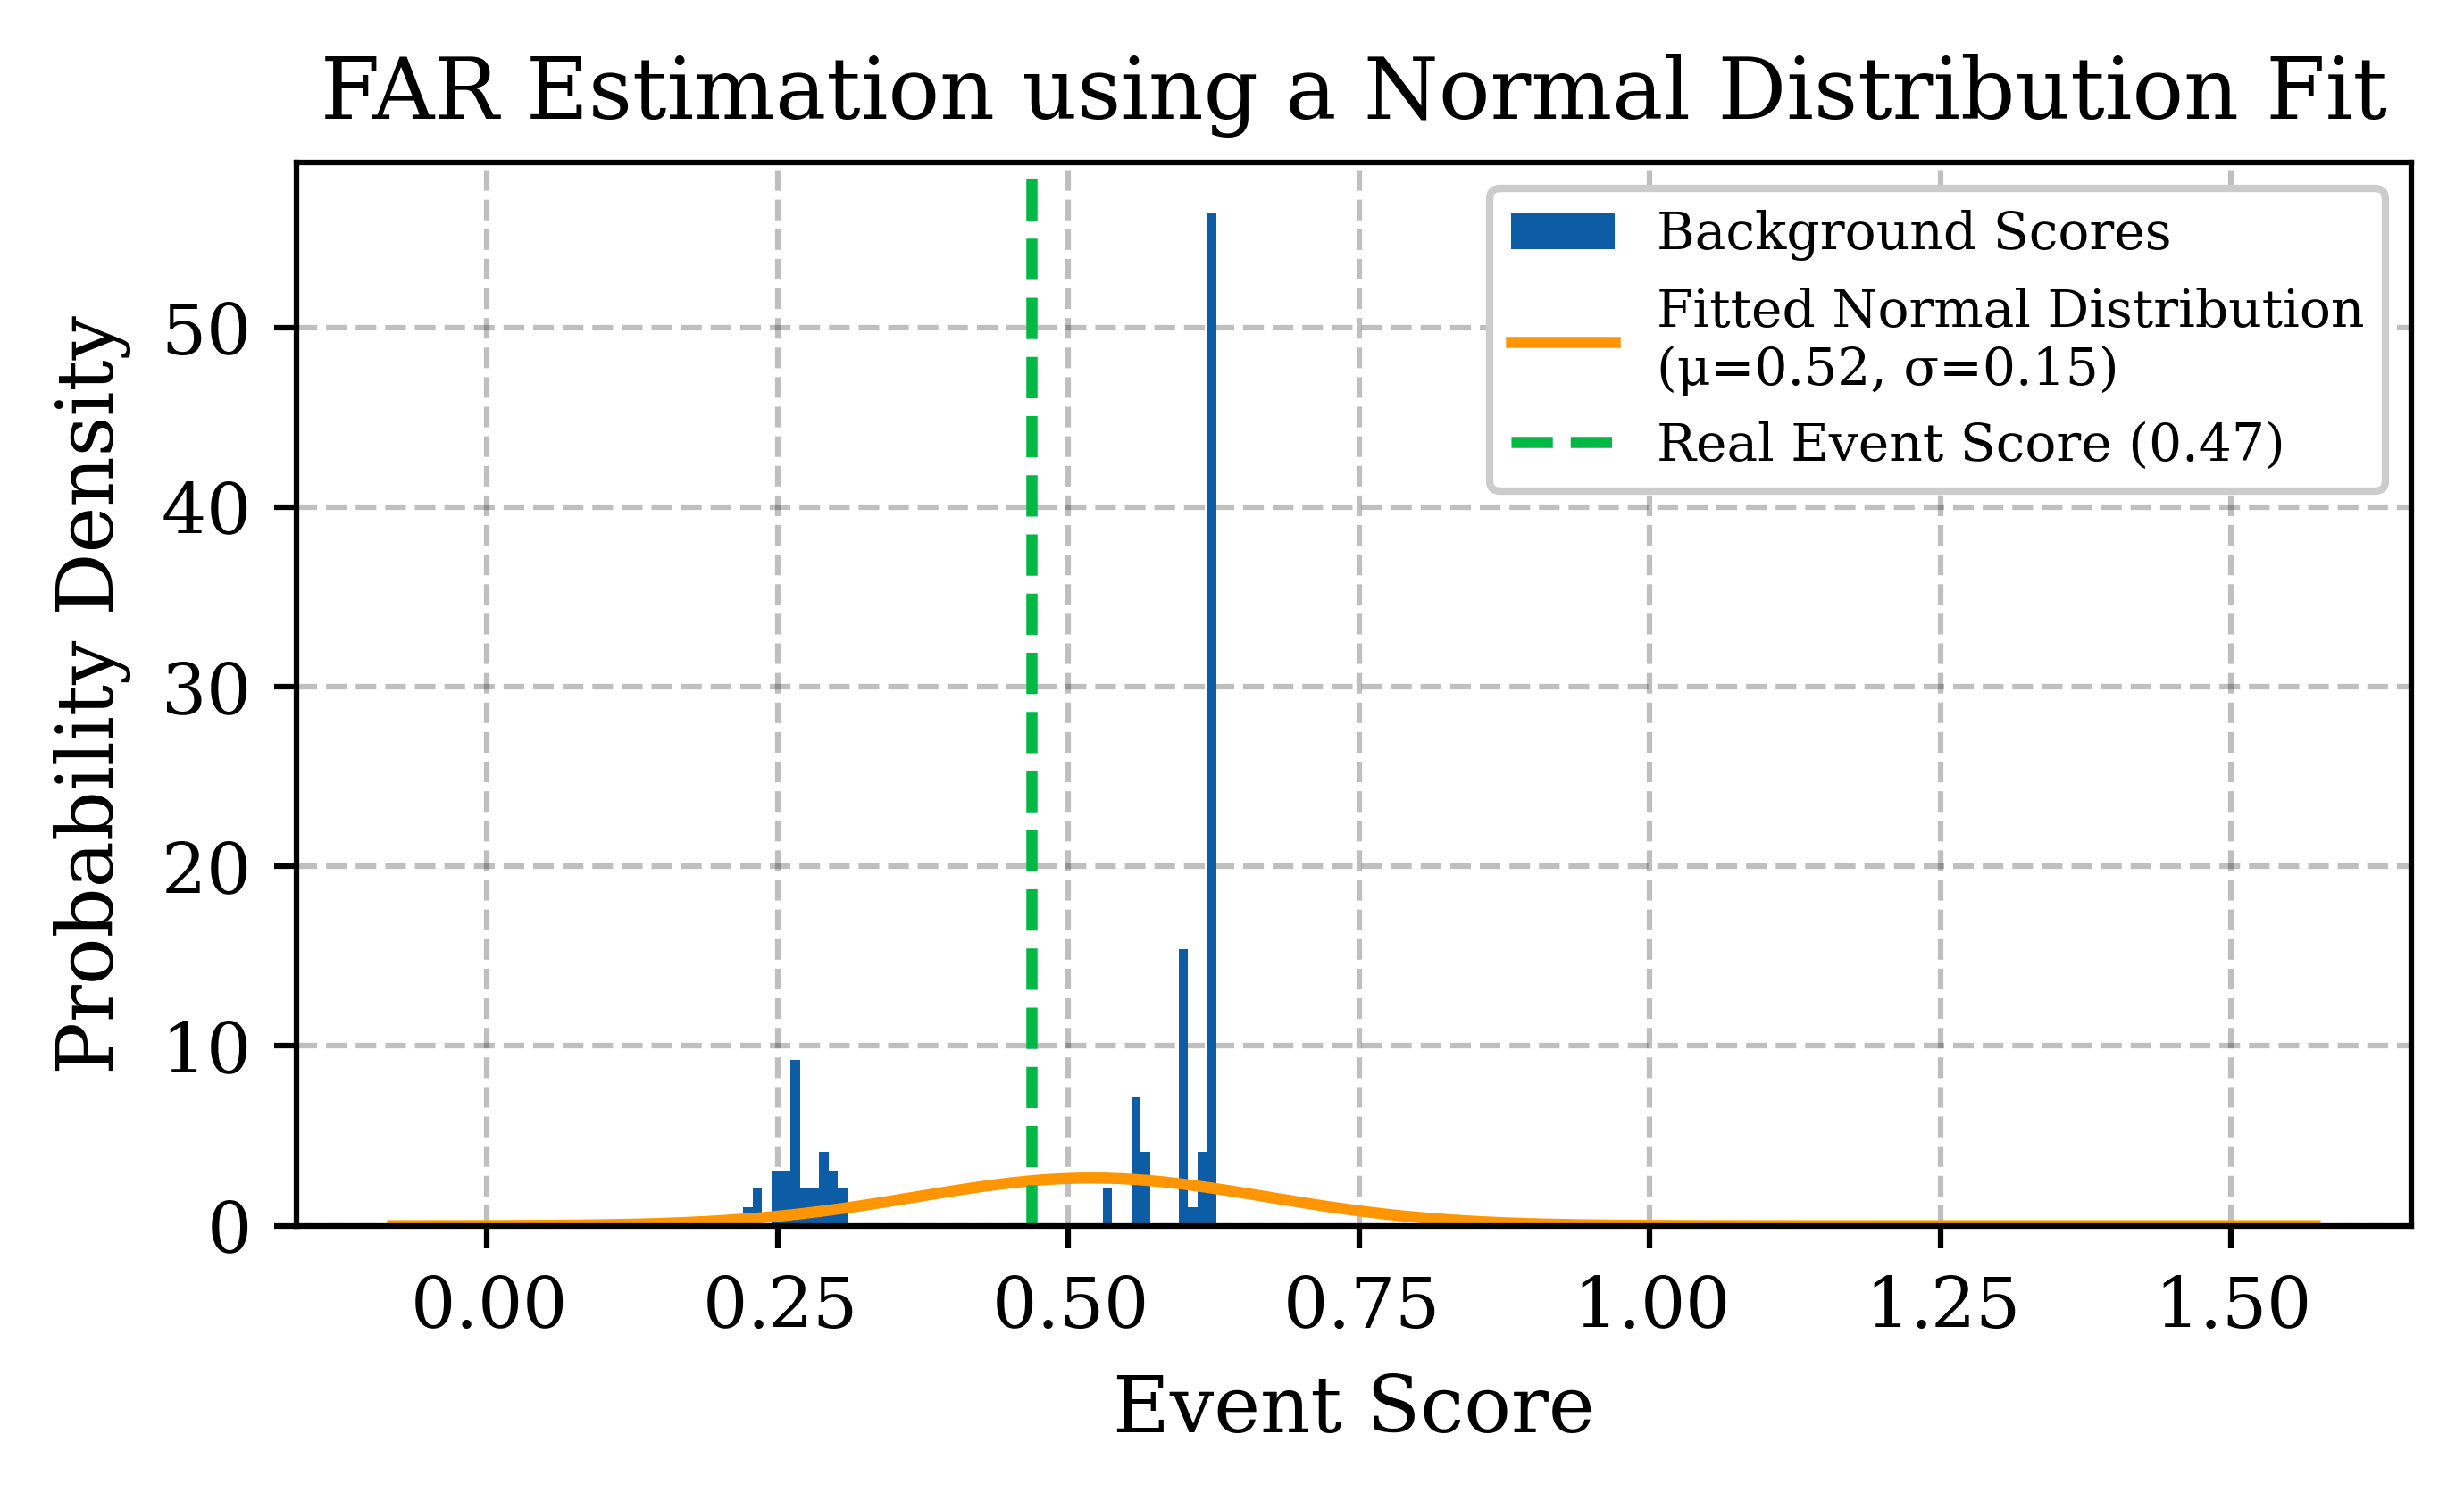

In [8]:
from scipy.stats import norm

def evaluate_far_with_normal_fit(S_real, background_scores):
    """
    通过将正态分布拟合到背景得分，来评估假警报率(FAR)和统计显著性。

    参数:
    S_real (float): 真实候选事件的得分。
    background_scores (np.ndarray): 来自时域平移实验的一系列背景事件得分。

    返回:
    dict: 包含评估结果的字典。
    """
    if not isinstance(background_scores, np.ndarray):
        background_scores = np.array(background_scores)

    # 1. 将正态分布拟合到背景数据上
    # norm.fit() 会返回最佳拟合的均值(mu)和标准差(sigma)
    mu, sigma_dist = norm.fit(background_scores)

    # 2. 计算假警报概率 (False Alarm Probability, FAP)
    # FAP = P(背景得分 >= 真实得分)
    # 我们可以使用生存函数 (Survival Function, sf)，其定义就是 1 - CDF。
    fap_fitted = norm.sf(S_real, loc=mu, scale=sigma_dist)

    # 3. 计算统计显著性 (Significance in sigma)
    # 对于正态分布，这非常直观：就是计算真实得分偏离背景均值多少个标准差。
    # 这也被称为 Z-score。
    significance_sigma = (S_real - mu) / sigma_dist

    # --- 准备结果 ---
    results = {
        'mu': mu,
        'sigma_dist': sigma_dist,
        'fap_fitted': fap_fitted,
        'significance_sigma': significance_sigma
    }
    
    # --- 打印结果 ---
    print("\n正态分布拟合外推法")
    print(f"拟合的正态分布参数: μ (均值) = {mu:.2f}, σ (标准差) = {sigma_dist:.2f}")
    print(f"根据拟合分布，得分>={S_real:.2f}的概率(FAP)为: {fap_fitted:.2e}")
    print(f"对应的统计显著性为: {significance_sigma:.2f} σ (sigma)")
    
    return results

# --- 示例：如何使用此函数 ---
if __name__ == '__main__':
    # --- 步骤二：调用函数进行评估 ---
    fit_results = evaluate_far_with_normal_fit(S_real, background_scores)

    # --- 步骤三：可视化结果 ---
    with ypu.temp_style(["ysy_academic", "science_color"]):
        plt.figure()
        plt.hist(background_scores, bins=50, density=True, alpha=1, label='Background Scores', color='C0')

        # 绘制拟合的正态分布曲线
        mu_fit = fit_results['mu']
        sigma_fit = fit_results['sigma_dist']
        x_axis = np.linspace(mu_fit - 4*sigma_fit, mu_fit + 7*sigma_fit, 400)
        y_axis = norm.pdf(x_axis, loc=mu_fit, scale=sigma_fit)
        plt.plot(x_axis, y_axis, color='C2', label=f'Fitted Normal Distribution\n(μ={mu_fit:.2f}, σ={sigma_fit:.2f})')

        # 标记真实事件的得分位置
        plt.axvline(S_real, color='C1', linestyle='--', label=f'Real Event Score ({S_real:.2f})')

        plt.title('FAR Estimation using a Normal Distribution Fit')
        plt.xlabel('Event Score')
        plt.ylabel('Probability Density')
        plt.legend(fontsize=7)
        plt.grid(True, alpha=0.25)
        plt.tight_layout()
        plt.show()